<a href="https://colab.research.google.com/github/flohmannjr/tensorflow_curso/blob/main/TensorFlow_MP2_1_SkimLit%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Milestone Project 2.1: SkimLit+

Esta é a continuidade do projeto SkimLit, segundo milestone project do curso TensorFlow Developer Certificate in 2023: Zero to Mastery. https://www.udemy.com/share/104ssS3@m--2vC9jNX6kIapUf0IUOOxnuj8_1SisbHiZTsJDQ5z2toWaLfaenc4bvZ4i2Yd5/

# Importações

In [1]:
import tensorflow as tf
import tensorflow_hub as hub

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.data import AUTOTUNE, Dataset
from tensorflow.keras import Model
from tensorflow.keras.layers import Bidirectional, Concatenate, Dense, Dropout, Embedding, Input, Lambda, LSTM, TextVectorization
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.utils import plot_model

from sklearn.preprocessing import LabelEncoder, OneHotEncoder

# Configurações, constantes e variáveis globais

In [2]:
plt.rcParams['figure.figsize'] = [8, 5]
plt.rcParams['figure.dpi'] = 100

plt.style.use('seaborn-darkgrid')

COR = '#007f66'

DIRETORIO = '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign'

LIMITE_DICIONARIO = 68000
LIMITE_CARACTERES = 80

LIMITE_INCORPORADOR = 256
LIMITE_INCORPORADOR_CARACTERES = 32
LIMITE_VETOR_TEXTO = 128

LOTE_TAMANHO = 32

ENTRADA_FORMATO = (1,)
ENTRADA_TIPO = tf.string

ATIVACAO_CNN = 'relu'
ATIVACAO_RNN = 'tanh'
ATIVACAO_SAIDA = 'softmax'

SUAVIZACAO = 0.2
APRENDIZADO = 0.001
METRICAS = ['accuracy']

ITERACOES = 3

avaliacoes = [None] * 5

# Funções

In [3]:
!wget https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py

--2023-02-07 23:11:04--  https://raw.githubusercontent.com/flohmannjr/tensorflow_curso/main/funcoes.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7753 (7.6K) [text/plain]
Saving to: ‘funcoes.py’

funcoes.py          100%[===================>]   7.57K  --.-KB/s    in 0s      

2023-02-07 23:11:04 (78.4 MB/s) - ‘funcoes.py’ saved [7753/7753]



In [4]:
from funcoes import avaliar_modelo, grafico_historico_por_iteracao, preprocessar_texto

# Dados

In [5]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git

Cloning into 'pubmed-rct'...
remote: Enumerating objects: 33, done.
remote: Counting objects: 100% (8/8), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 33 (delta 5), reused 5 (delta 5), pack-reused 25
Unpacking objects: 100% (33/33), 177.08 MiB | 11.09 MiB/s, done.


In [6]:
df_treino    = pd.DataFrame(preprocessar_texto(f'{DIRETORIO}/train.txt'))
df_validacao = pd.DataFrame(preprocessar_texto(f'{DIRETORIO}/dev.txt'))

codificador_onehot = OneHotEncoder(sparse=False)

rotulos_onehot_treino    = codificador_onehot.fit_transform(df_treino['classe'].to_numpy().reshape(-1, 1))
rotulos_onehot_validacao = codificador_onehot.transform(df_validacao['classe'].to_numpy().reshape(-1, 1))

codificador_int = LabelEncoder()

rotulos_int_treino    = codificador_int.fit_transform(df_treino['classe'].to_numpy())
rotulos_int_validacao = codificador_int.transform(df_validacao['classe'].to_numpy())

classes = codificador_int.classes_

palavras_por_texto_98   = int(np.percentile([len(texto.split()) for texto in df_treino['texto']], 98))
caracteres_por_texto_98 = int(np.percentile([len(texto) for texto in df_treino['texto']], 98))

lista_caracteres_treino    = [" ".join(list(texto)) for texto in df_treino['texto']]
lista_caracteres_validacao = [" ".join(list(texto)) for texto in df_validacao['texto']]

numero_linha_98 = int(np.percentile(df_treino['numero'], 98))

linhas_numero_onehot_treino    = tf.one_hot(df_treino['numero'], depth=numero_linha_98)
linhas_numero_onehot_validacao = tf.one_hot(df_validacao['numero'], depth=numero_linha_98)

total_linhas_98 = int(np.percentile(df_treino['total'], 98))

linhas_total_onehot_treino    = tf.one_hot(df_treino['total'], depth=total_linhas_98)
linhas_total_onehot_validacao = tf.one_hot(df_validacao['total'], depth=total_linhas_98)

dados_hibridos_linhas_treino_textos  = Dataset.from_tensor_slices((df_treino['texto'], lista_caracteres_treino, linhas_numero_onehot_treino, linhas_total_onehot_treino))
dados_hibridos_linhas_treino_rotulos = Dataset.from_tensor_slices(rotulos_onehot_treino)
dados_hibridos_linhas_treino         = Dataset.zip((dados_hibridos_linhas_treino_textos, dados_hibridos_linhas_treino_rotulos))
dados_hibridos_linhas_treino         = dados_hibridos_linhas_treino.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

dados_hibridos_linhas_validacao_textos  = Dataset.from_tensor_slices((df_validacao['texto'], lista_caracteres_validacao, linhas_numero_onehot_validacao, linhas_total_onehot_validacao))
dados_hibridos_linhas_validacao_rotulos = Dataset.from_tensor_slices(rotulos_onehot_validacao)
dados_hibridos_linhas_validacao         = Dataset.zip((dados_hibridos_linhas_validacao_textos, dados_hibridos_linhas_validacao_rotulos))
dados_hibridos_linhas_validacao         = dados_hibridos_linhas_validacao.batch(LOTE_TAMANHO).prefetch(AUTOTUNE)

# Camadas auxiliares

In [7]:
vetorizador_palavras = TextVectorization(max_tokens=LIMITE_DICIONARIO,
                                         output_mode='int',
                                         output_sequence_length=palavras_por_texto_98,
                                         name='vetorizador_palavras')

vetorizador_palavras.adapt(df_treino['texto'])

vocabulario_palavras = vetorizador_palavras.get_vocabulary()

incorporador_palavras = Embedding(input_dim=len(vocabulario_palavras),
                                  output_dim=LIMITE_INCORPORADOR,
                                  mask_zero=True,
                                  input_length=palavras_por_texto_98,
                                  name='incorporador_palavras')

vetorizador_caracteres = TextVectorization(max_tokens=LIMITE_CARACTERES,
                                           output_mode='int',
                                           output_sequence_length=caracteres_por_texto_98,
                                           name='vetorizador_caracteres')

vetorizador_caracteres.adapt(lista_caracteres_treino)

vocabulario_caracteres = vetorizador_caracteres.get_vocabulary()

incorporador_caracteres = Embedding(input_dim=len(vocabulario_caracteres),
                                    output_dim=LIMITE_INCORPORADOR_CARACTERES,
                                    mask_zero=True,
                                    input_length=caracteres_por_texto_98,
                                    name='incorporador_caracteres')

incorporador_use = hub.KerasLayer(handle='https://tfhub.dev/google/universal-sentence-encoder/4',
                                  trainable=False,
                                  name='incorporador_use')

# Modelo 0: Modelo 5 do projeto original

## Modelo com incorporação de palavras

In [8]:
modelo_nome = 'modelo_incorporacao_palavras'

entradas = Input(shape=[], dtype=ENTRADA_TIPO, name='camada_entrada_palavras')

incorporador_hub = incorporador_use(entradas)

saidas = Dense(LIMITE_INCORPORADOR, activation=ATIVACAO_CNN, name='camada_relu_palavras')(incorporador_hub)

modelo_incorporacao_palavras = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Modelo com incorporação de caracteres

In [9]:
modelo_nome = 'modelo_incorporacao_caracteres'

entradas = Input(shape=ENTRADA_FORMATO, dtype=ENTRADA_TIPO, name='camada_entrada_caracteres')

camadas = vetorizador_caracteres(entradas)
camadas = incorporador_caracteres(camadas)

saidas = Bidirectional(layer=LSTM(units=LIMITE_INCORPORADOR_CARACTERES, activation=ATIVACAO_RNN), name='camada_bi_lstm_caracteres')(camadas)

modelo_incorporacao_caracteres = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Combinação dos modelos de incorporação

In [10]:
combinacao_incorporacao = Concatenate(name="camada_combinacao_incorporacao")([modelo_incorporacao_palavras.output,
                                                                              modelo_incorporacao_caracteres.output])

## Camadas de abandono

In [11]:
abandonos_incorporacao = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_incorporacao_relu')(combinacao_incorporacao)
abandonos_incorporacao = Dropout(rate=0.5, name='camada_abandonos_incorporacao')(abandonos_incorporacao)

## Modelo para o número de linhas

In [12]:
modelo_nome = 'modelo_numero_linhas'

entradas = Input(shape=(numero_linha_98,), dtype=linhas_numero_onehot_treino.dtype, name='camada_entrada_numero_linhas')

saidas = Dense(numero_linha_98 * 2, activation=ATIVACAO_CNN, name='camada_relu_numero_linhas')(entradas)

modelo_numero_linhas = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Modelo para o total de linhas

In [13]:
modelo_nome = 'modelo_total_linhas'

entradas = Input(shape=(total_linhas_98,), dtype=linhas_total_onehot_treino.dtype, name='camada_entrada_total_linhas')

saidas = Dense(total_linhas_98 * 2, activation=ATIVACAO_CNN, name='camada_relu_total_linhas')(entradas)

modelo_total_linhas = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Combinação dos modelos de incorporação e linhas

In [14]:
combinacao_linhas = Concatenate(name="camada_combinacao_linhas")([abandonos_incorporacao,
                                                                  modelo_numero_linhas.output,
                                                                  modelo_total_linhas.output])

## Camadas de abandono e saída

In [15]:
abandonos_linhas = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_linhas_relu')(combinacao_linhas)
abandonos_linhas = Dropout(rate=0.5, name='camada_abandonos_linhas')(abandonos_linhas)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(abandonos_linhas)

## Modelo com incorporação híbrida e linhas

In [16]:
modelo_nome = 'modelo_0_modelo_5_original'

modelo = Model(inputs=[modelo_incorporacao_palavras.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

## Verificação do modelo

In [17]:
modelo.summary()

Model: "modelo_0_modelo_5_original"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 camada_entrada_caracteres (Inp  [(None, 1)]         0           []                               
 utLayer)                                                                                         
                                                                                                  
 camada_entrada_palavras (Input  [(None,)]           0           []                               
 Layer)                                                                                           
                                                                                                  
 vetorizador_caracteres (TextVe  (None, 347)         0           ['camada_entrada_caracteres[0][0]
 ctorization)                                                    ']      

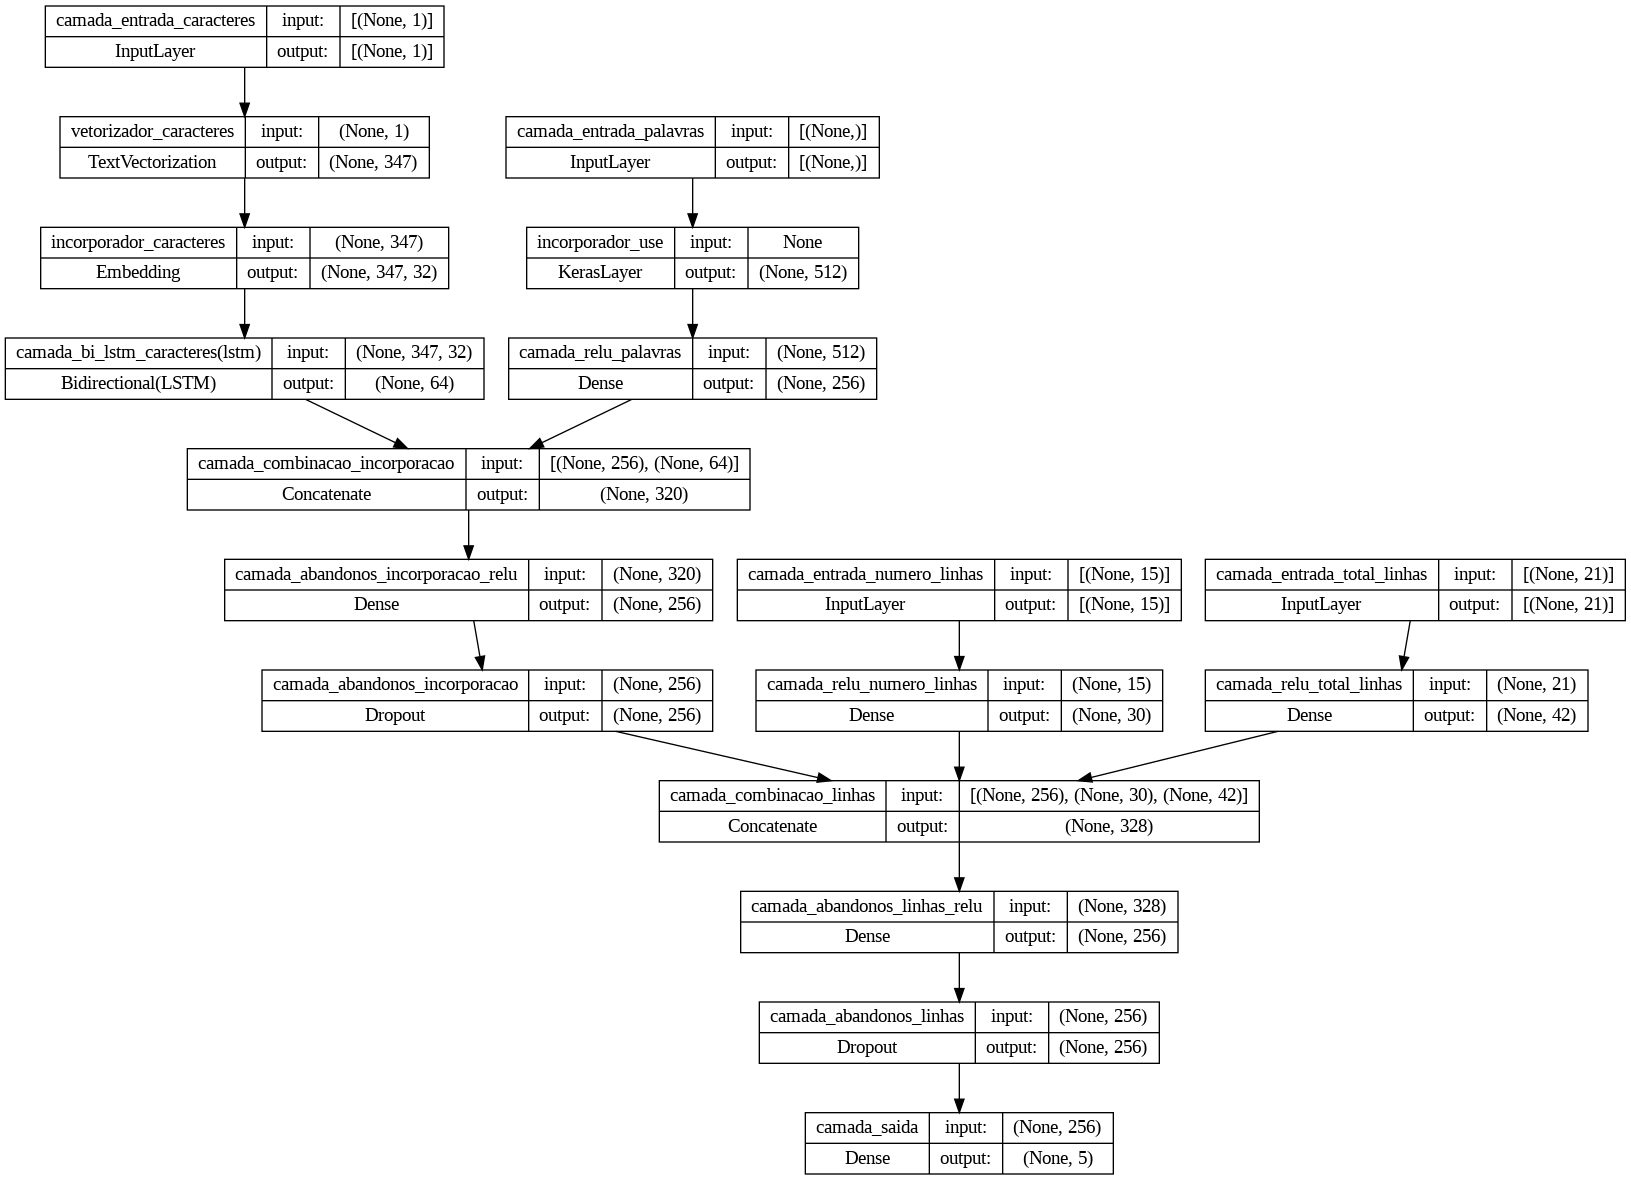

In [18]:
plot_model(modelo, show_shapes=True)

## Compilação com suavização de rótulo

In [19]:
modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

## Finalização do modelo

In [20]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=ITERACOES,
                       validation_data=dados_hibridos_linhas_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 339s 57ms/step - loss: 0.9283 - accuracy: 0.8353 - val_loss: 0.8618 - val_accuracy: 0.8670
Epoch 2/3
5627/5627 [==============================] - 317s 56ms/step - loss: 0.8814 - accuracy: 0.8667 - val_loss: 0.8561 - val_accuracy: 0.8730
Epoch 3/3
5627/5627 [==============================] - 319s 57ms/step - loss: 0.8668 - accuracy: 0.8778 - val_loss: 0.8562 - val_accuracy: 0.8716


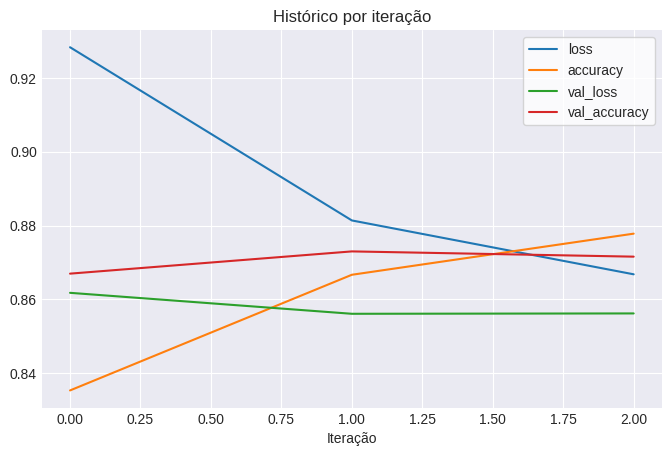

In [21]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 26s 25ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.70      0.88      0.78      3449
 CONCLUSIONS       0.92      0.88      0.90      4582
     METHODS       0.92      0.91      0.91      9964
   OBJECTIVE       0.85      0.46      0.60      2376
     RESULTS       0.88      0.93      0.90      9841

    accuracy                           0.87     30212
   macro avg       0.85      0.81      0.82     30212
weighted avg       0.88      0.87      0.87     30212



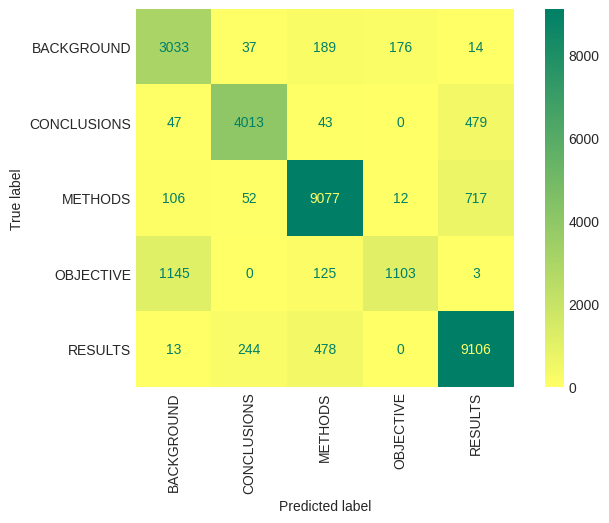

In [22]:
probabilidades = modelo.predict(dados_hibridos_linhas_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[0]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [23]:
avaliacoes[0]

{'acuracia': 0.8715742089236065,
 'precisao': 0.8764011347541206,
 'revocacao': 0.8715742089236065,
 'pontuacao-f1': 0.8679977437844223}

# Modelo 1: Substituição do incorporador de palavras

## Modelo com incorporação de palavras particularizada

In [24]:
modelo_nome = 'modelo_incorporacao_palavras_particularizada'

entradas = Input(shape=[], dtype=ENTRADA_TIPO, name='camada_entrada_palavras')

camadas = vetorizador_palavras(entradas)
camadas = incorporador_palavras(camadas)

saidas = Bidirectional(layer=LSTM(units=int(LIMITE_INCORPORADOR / 2), activation=ATIVACAO_RNN), name='camada_bi_lstm_palavras')(camadas)

modelo_incorporacao_palavras_particularizada = Model(inputs=entradas, outputs=saidas, name=modelo_nome)

## Reuso de camadas anteriores ajustadas

In [25]:
combinacao_incorporacao = Concatenate(name="camada_combinacao_incorporacao")([modelo_incorporacao_palavras_particularizada.output,
                                                                              modelo_incorporacao_caracteres.output])

abandonos_incorporacao = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_incorporacao_relu')(combinacao_incorporacao)
abandonos_incorporacao = Dropout(rate=0.5, name='camada_abandonos_incorporacao')(abandonos_incorporacao)

combinacao_linhas = Concatenate(name="camada_combinacao_linhas")([abandonos_incorporacao,
                                                                  modelo_numero_linhas.output,
                                                                  modelo_total_linhas.output])

abandonos_linhas = Dense(LIMITE_VETOR_TEXTO * 2, activation=ATIVACAO_CNN, name='camada_abandonos_linhas_relu')(combinacao_linhas)
abandonos_linhas = Dropout(rate=0.5, name='camada_abandonos_linhas')(abandonos_linhas)

saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(abandonos_linhas)

modelo_nome = 'modelo_1_incorporacao_palavras_particularizada'

modelo = Model(inputs=[modelo_incorporacao_palavras_particularizada.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

## Verificação do modelo

In [26]:
modelo.summary()

Model: "modelo_1_incorporacao_palavras_particularizada"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 camada_entrada_palavras (Input  [(None,)]           0           []                               
 Layer)                                                                                           
                                                                                                  
 camada_entrada_caracteres (Inp  [(None, 1)]         0           []                               
 utLayer)                                                                                         
                                                                                                  
 vetorizador_palavras (TextVect  (None, 68)          0           ['camada_entrada_palavras[0][0]']
 orization)                                          

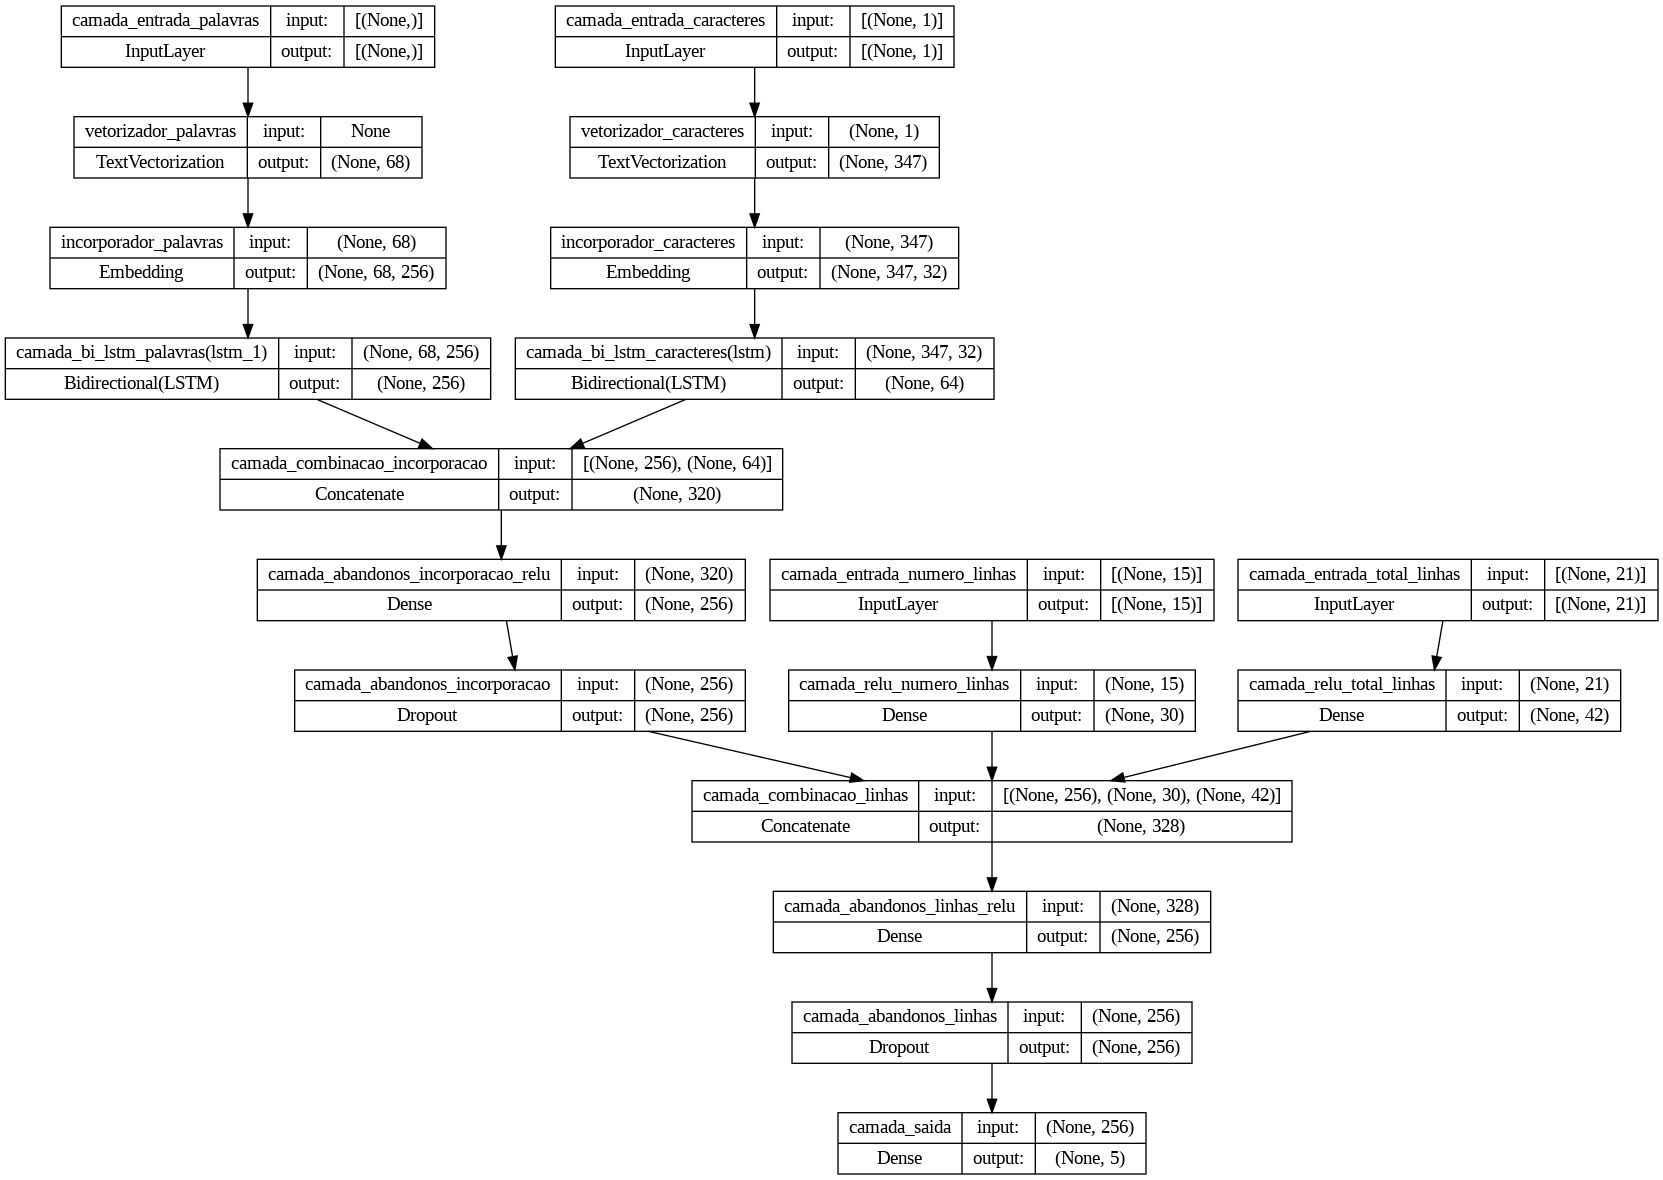

In [27]:
plot_model(modelo, show_shapes=True)

## Finalização do modelo

In [28]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=ITERACOES,
                       validation_data=dados_hibridos_linhas_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 406s 70ms/step - loss: 0.8943 - accuracy: 0.8607 - val_loss: 0.8405 - val_accuracy: 0.8867
Epoch 2/3
5627/5627 [==============================] - 389s 69ms/step - loss: 0.8281 - accuracy: 0.9050 - val_loss: 0.8491 - val_accuracy: 0.8799
Epoch 3/3
5627/5627 [==============================] - 389s 69ms/step - loss: 0.7882 - accuracy: 0.9343 - val_loss: 0.8618 - val_accuracy: 0.8727


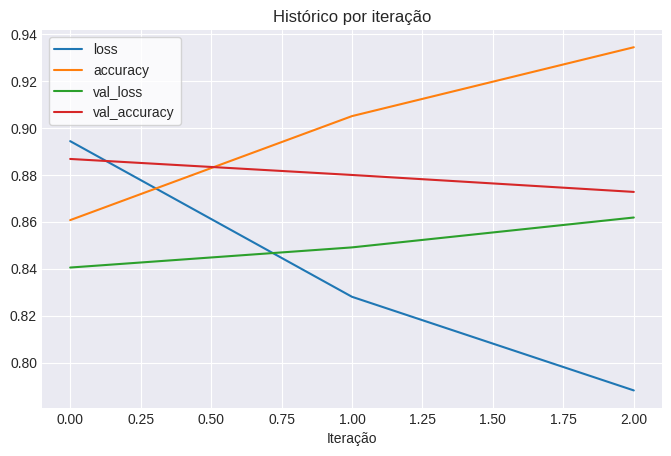

In [29]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 24s 19ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.72      0.80      0.76      3449
 CONCLUSIONS       0.92      0.87      0.90      4582
     METHODS       0.92      0.92      0.92      9964
   OBJECTIVE       0.73      0.56      0.63      2376
     RESULTS       0.89      0.93      0.91      9841

    accuracy                           0.87     30212
   macro avg       0.84      0.81      0.82     30212
weighted avg       0.87      0.87      0.87     30212



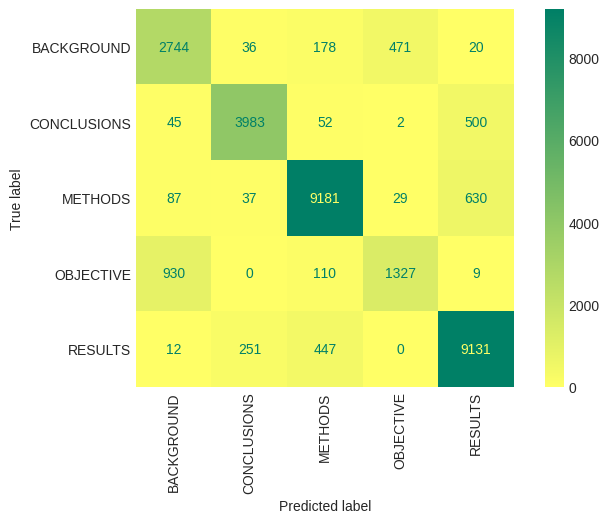

In [30]:
probabilidades = modelo.predict(dados_hibridos_linhas_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[1]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [31]:
avaliacoes[1]

{'acuracia': 0.8726995895670594,
 'precisao': 0.8721655971144417,
 'revocacao': 0.8726995895670594,
 'pontuacao-f1': 0.8710780513682834}

# Modelo 2: Otimizador de descida de gradiente estocástica

## Reuso de camadas anteriores ajustadas

In [32]:
modelo_nome = 'modelo_2_otimizador_sgd'

modelo = Model(inputs=[modelo_incorporacao_palavras_particularizada.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

## Compilação com otimizador de descida de gradiente estocástica

In [33]:
modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=SGD(learning_rate=APRENDIZADO),
               metrics=METRICAS)

## Verificação do modelo

In [34]:
modelo.summary()

Model: "modelo_2_otimizador_sgd"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 camada_entrada_palavras (Input  [(None,)]           0           []                               
 Layer)                                                                                           
                                                                                                  
 camada_entrada_caracteres (Inp  [(None, 1)]         0           []                               
 utLayer)                                                                                         
                                                                                                  
 vetorizador_palavras (TextVect  (None, 68)          0           ['camada_entrada_palavras[0][0]']
 orization)                                                                 

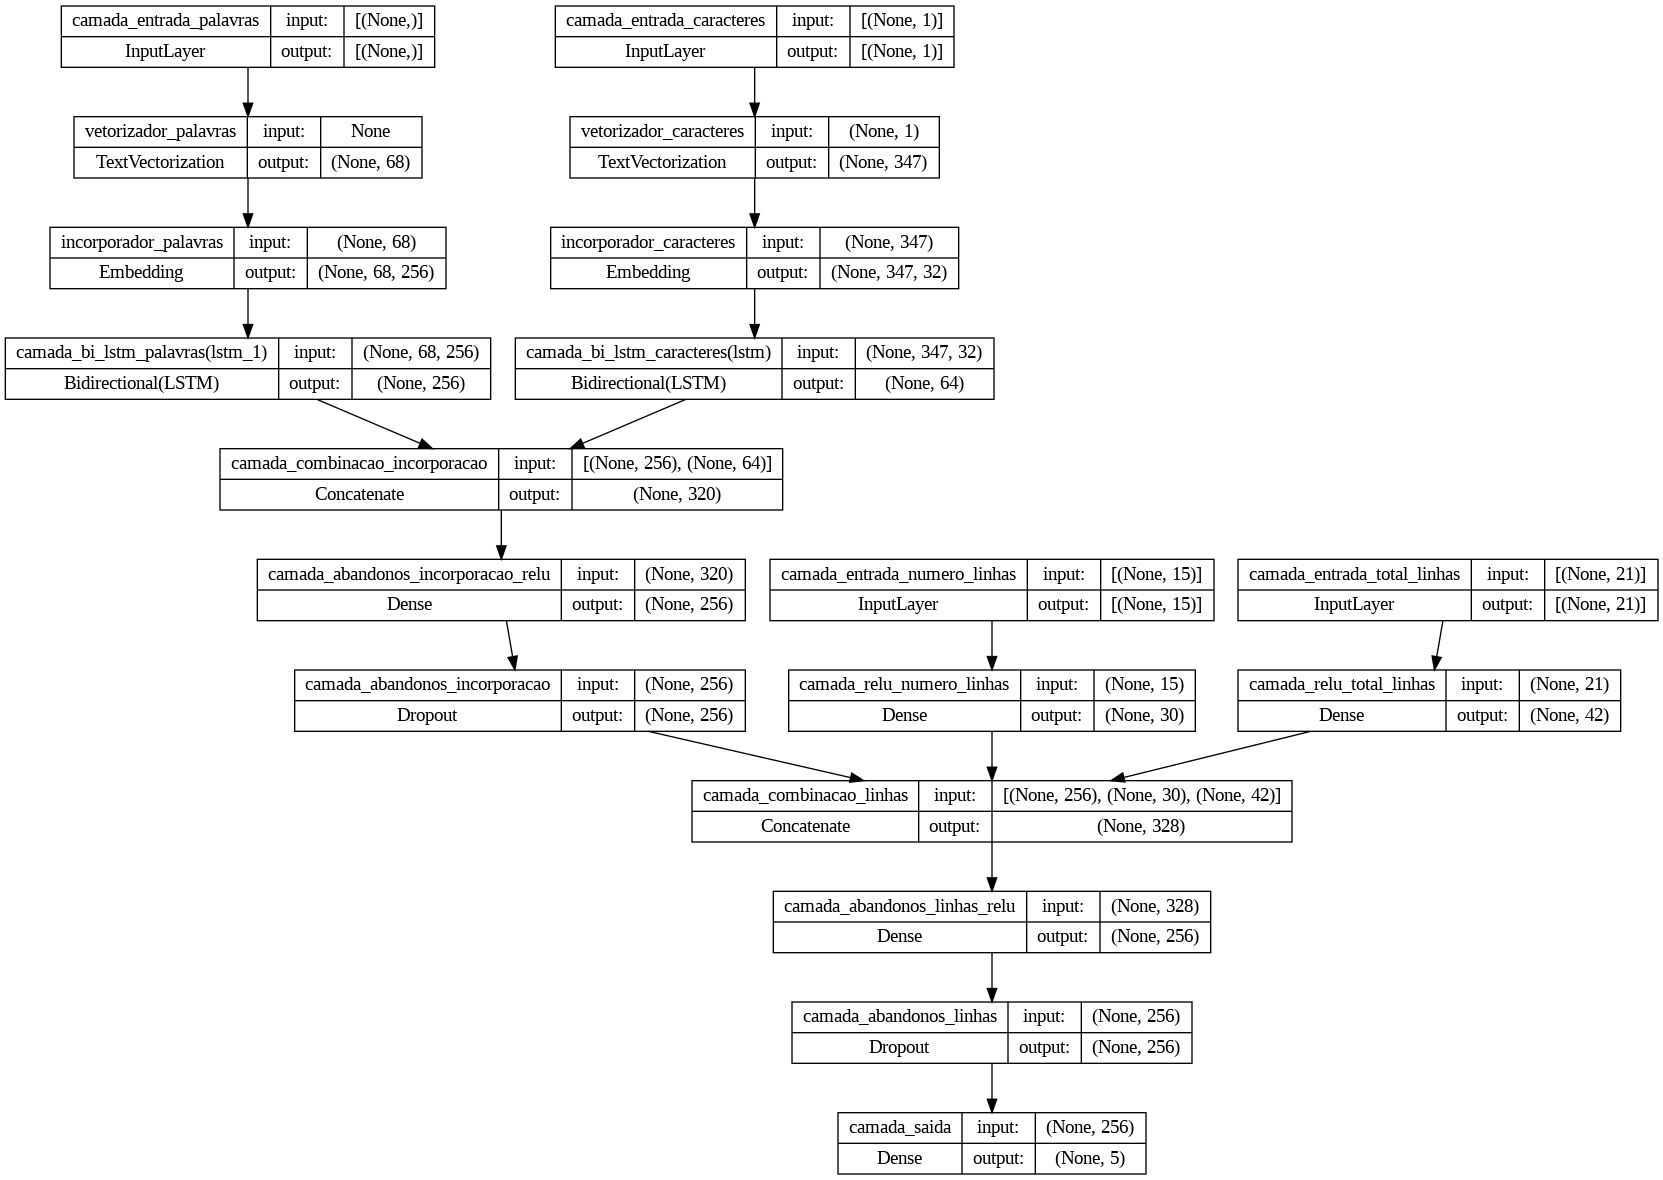

In [35]:
plot_model(modelo, show_shapes=True)

## Finalização do modelo

In [36]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=ITERACOES,
                       validation_data=dados_hibridos_linhas_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 369s 63ms/step - loss: 0.7662 - accuracy: 0.9473 - val_loss: 0.8564 - val_accuracy: 0.8761
Epoch 2/3
5627/5627 [==============================] - 349s 62ms/step - loss: 0.7644 - accuracy: 0.9487 - val_loss: 0.8557 - val_accuracy: 0.8769
Epoch 3/3
5627/5627 [==============================] - 352s 63ms/step - loss: 0.7633 - accuracy: 0.9499 - val_loss: 0.8555 - val_accuracy: 0.8765


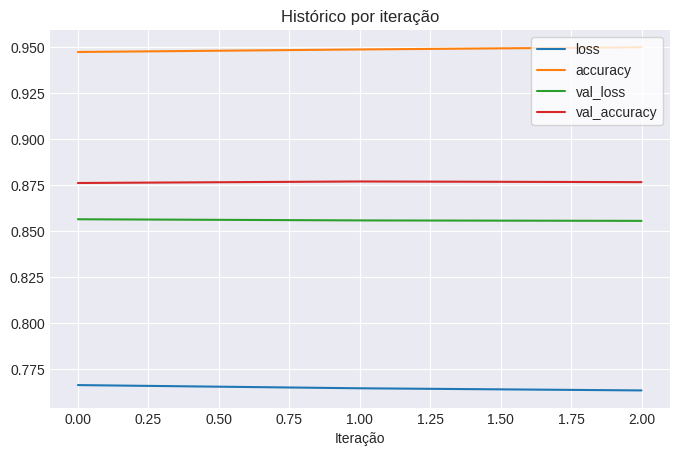

In [37]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 23s 20ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.72      0.78      0.75      3449
 CONCLUSIONS       0.91      0.90      0.90      4582
     METHODS       0.92      0.93      0.93      9964
   OBJECTIVE       0.70      0.60      0.64      2376
     RESULTS       0.91      0.91      0.91      9841

    accuracy                           0.88     30212
   macro avg       0.83      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212



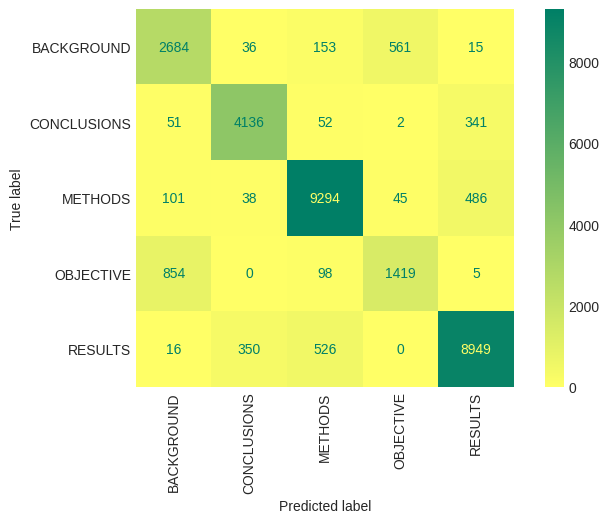

In [38]:
probabilidades = modelo.predict(dados_hibridos_linhas_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[2]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [39]:
avaliacoes[2]

{'acuracia': 0.8765391235270753,
 'precisao': 0.8756545184388317,
 'revocacao': 0.8765391235270753,
 'pontuacao-f1': 0.8756442057484183}

# Modelo 3: Ajuste na taxa de aprendizado do otimizador

## Reuso de camadas anteriores ajustadas

In [40]:
modelo_nome = 'modelo_3_ajuste_aprendizado'

modelo = Model(inputs=[modelo_incorporacao_palavras_particularizada.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

## Ajuste na taxa de aprendizado do otimizador

In [41]:
modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=SGD(),
               metrics=METRICAS)

lrs = tf.keras.callbacks.LearningRateScheduler(lambda epoch: tf.add(0.001, tf.multiply(0.002, epoch)))

## Finalização do modelo

In [42]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=6,
                       validation_data=dados_hibridos_linhas_validacao,
                       callbacks=[lrs],
                       verbose=1)

Epoch 1/6
5627/5627 [==============================] - 374s 64ms/step - loss: 0.7624 - accuracy: 0.9502 - val_loss: 0.8553 - val_accuracy: 0.8768 - lr: 0.0010
Epoch 2/6
5627/5627 [==============================] - 349s 62ms/step - loss: 0.7620 - accuracy: 0.9502 - val_loss: 0.8567 - val_accuracy: 0.8771 - lr: 0.0030
Epoch 3/6
5627/5627 [==============================] - 354s 63ms/step - loss: 0.7601 - accuracy: 0.9517 - val_loss: 0.8577 - val_accuracy: 0.8768 - lr: 0.0050
Epoch 4/6
5627/5627 [==============================] - 354s 63ms/step - loss: 0.7581 - accuracy: 0.9522 - val_loss: 0.8583 - val_accuracy: 0.8765 - lr: 0.0070
Epoch 5/6
5627/5627 [==============================] - 355s 63ms/step - loss: 0.7571 - accuracy: 0.9536 - val_loss: 0.8594 - val_accuracy: 0.8762 - lr: 0.0090
Epoch 6/6
5627/5627 [==============================] - 356s 63ms/step - loss: 0.7553 - accuracy: 0.9548 - val_loss: 0.8599 - val_accuracy: 0.8759 - lr: 0.0110


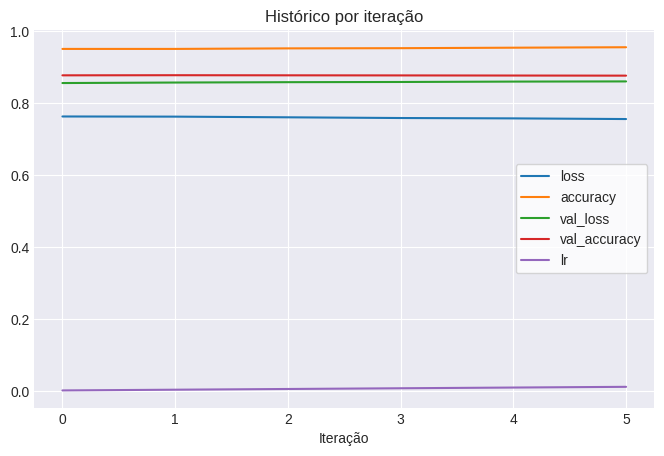

In [43]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 23s 20ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.72      0.77      0.74      3449
 CONCLUSIONS       0.91      0.90      0.91      4582
     METHODS       0.92      0.93      0.93      9964
   OBJECTIVE       0.68      0.60      0.64      2376
     RESULTS       0.91      0.91      0.91      9841

    accuracy                           0.88     30212
   macro avg       0.83      0.82      0.83     30212
weighted avg       0.88      0.88      0.88     30212



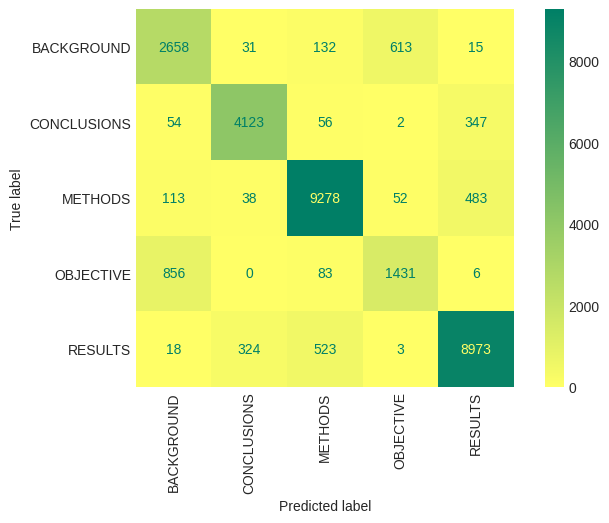

In [44]:
probabilidades = modelo.predict(dados_hibridos_linhas_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[3]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [45]:
avaliacoes[3]

{'acuracia': 0.8759102343439693,
 'precisao': 0.8753792606109981,
 'revocacao': 0.8759102343439693,
 'pontuacao-f1': 0.8753340277475392}

# Modelo 4: LSTM bidirecional após combinação dos modelos de incorporação e linhas

## Expansão de dimensões, LSTM bidirecional e abandono

In [46]:
abandonos_linhas = Lambda(lambda x: tf.expand_dims(x, axis=1), name='camada_lambda')(combinacao_linhas)
abandonos_linhas = Bidirectional(layer=LSTM(units=LIMITE_VETOR_TEXTO, activation=ATIVACAO_RNN), name='camada_linhas_bi_lstm')(abandonos_linhas)
abandonos_linhas = Dropout(rate=0.5, name='camada_abandonos_bi_lstm')(abandonos_linhas)

## Reuso de camadas anteriores ajustadas

In [47]:
saidas = Dense(len(classes), activation=ATIVACAO_SAIDA, name='camada_saida')(abandonos_linhas)

modelo_nome = 'modelo_4_linhas_bi_lstm'

modelo = Model(inputs=[modelo_incorporacao_palavras_particularizada.input,
                       modelo_incorporacao_caracteres.input,
                       modelo_numero_linhas.input,
                       modelo_total_linhas.input],
               outputs=saidas,
               name=modelo_nome)

modelo.compile(loss=CategoricalCrossentropy(label_smoothing=SUAVIZACAO),
               optimizer=Adam(learning_rate=APRENDIZADO),
               metrics=METRICAS)

## Verificação do modelo

In [48]:
modelo.summary()

Model: "modelo_4_linhas_bi_lstm"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 camada_entrada_palavras (Input  [(None,)]           0           []                               
 Layer)                                                                                           
                                                                                                  
 camada_entrada_caracteres (Inp  [(None, 1)]         0           []                               
 utLayer)                                                                                         
                                                                                                  
 vetorizador_palavras (TextVect  (None, 68)          0           ['camada_entrada_palavras[0][0]']
 orization)                                                                 

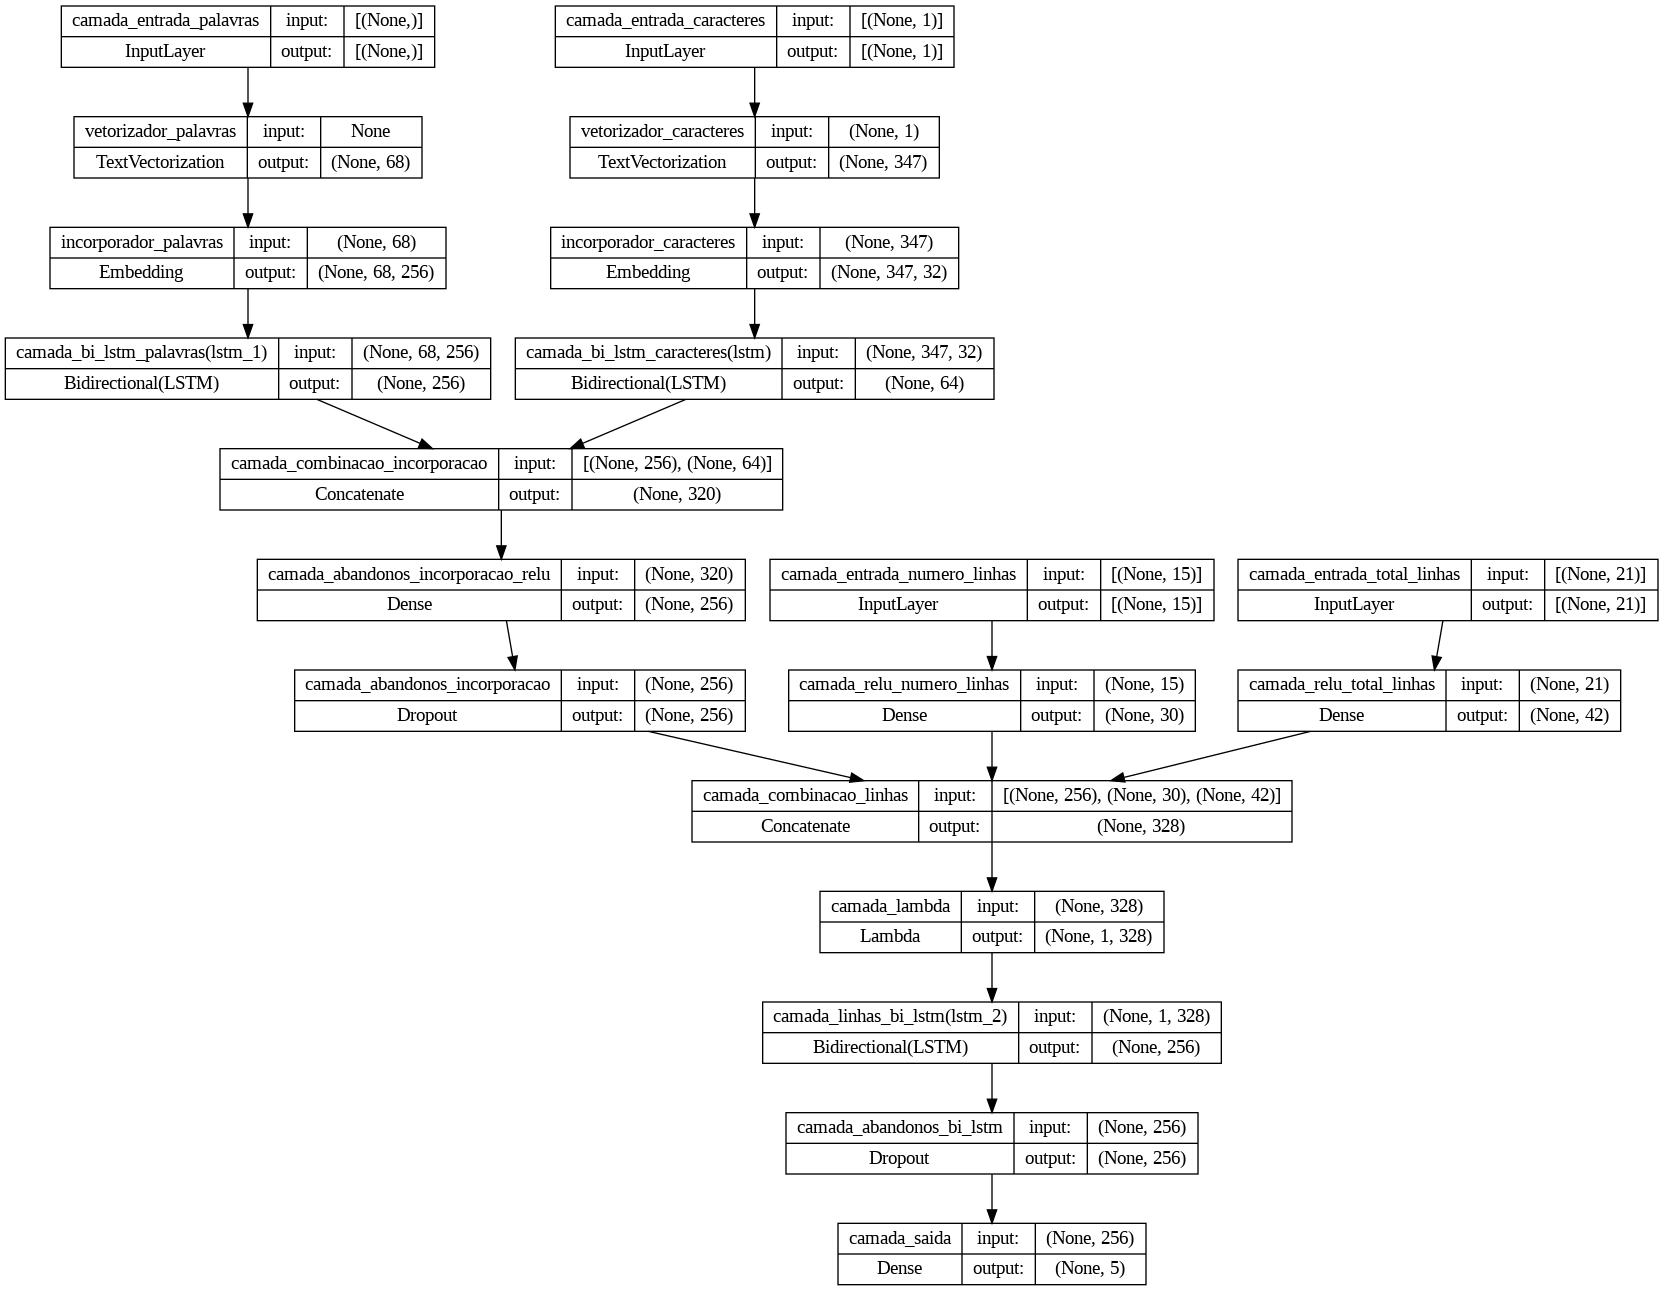

In [49]:
plot_model(modelo, show_shapes=True)

## Finalização do modelo

In [50]:
historico = modelo.fit(dados_hibridos_linhas_treino,
                       epochs=ITERACOES,
                       validation_data=dados_hibridos_linhas_validacao,
                       verbose=1)

Epoch 1/3
5627/5627 [==============================] - 445s 76ms/step - loss: 0.7560 - accuracy: 0.9532 - val_loss: 0.8774 - val_accuracy: 0.8681
Epoch 2/3
5627/5627 [==============================] - 418s 74ms/step - loss: 0.7233 - accuracy: 0.9708 - val_loss: 0.8925 - val_accuracy: 0.8648
Epoch 3/3
5627/5627 [==============================] - 415s 74ms/step - loss: 0.7102 - accuracy: 0.9784 - val_loss: 0.8990 - val_accuracy: 0.8659


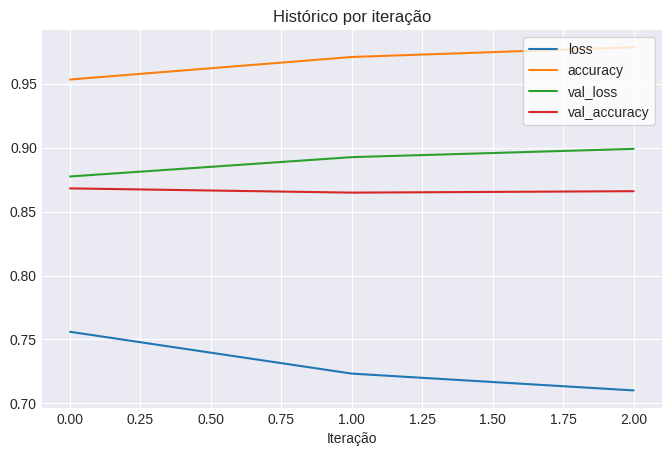

In [51]:
grafico_historico_por_iteracao(historico)

945/945 [==============================] - 25s 20ms/step
              precision    recall  f1-score   support

  BACKGROUND       0.70      0.77      0.73      3449
 CONCLUSIONS       0.89      0.89      0.89      4582
     METHODS       0.93      0.92      0.92      9964
   OBJECTIVE       0.66      0.58      0.62      2376
     RESULTS       0.90      0.91      0.91      9841

    accuracy                           0.87     30212
   macro avg       0.82      0.81      0.81     30212
weighted avg       0.87      0.87      0.87     30212



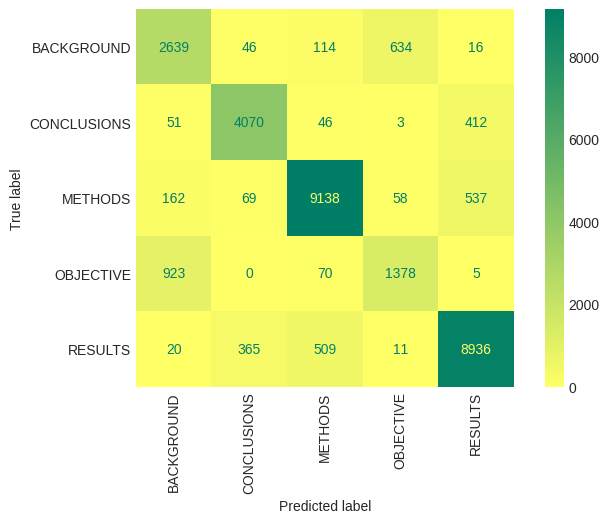

In [52]:
probabilidades = modelo.predict(dados_hibridos_linhas_validacao)
previsoes      = tf.argmax(probabilidades, axis=1)
avaliacoes[4]  = avaliar_modelo(rotulos_int_validacao, previsoes, classes)

In [53]:
avaliacoes[4]

{'acuracia': 0.8659142062756521,
 'precisao': 0.8660119772033599,
 'revocacao': 0.8659142062756521,
 'pontuacao-f1': 0.865552999252038}

# Comparação de modelos

In [54]:
avaliacoes = [a for a in avaliacoes if a is not None]

comparacao = pd.DataFrame(avaliacoes)
comparacao = comparacao.reset_index().melt(id_vars='index').rename(columns=str.title)

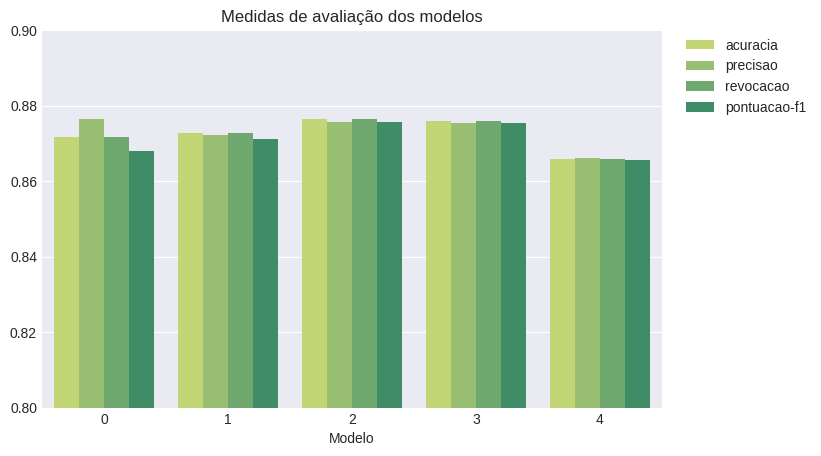

In [55]:
sns.barplot(data=comparacao, x='Index', y='Value', hue='Variable', palette='summer_r')

plt.ylim(0.80, 0.90)

plt.title('Medidas de avaliação dos modelos')
plt.xlabel('Modelo')
plt.ylabel('')

plt.legend(loc=(1.03, 0.76));

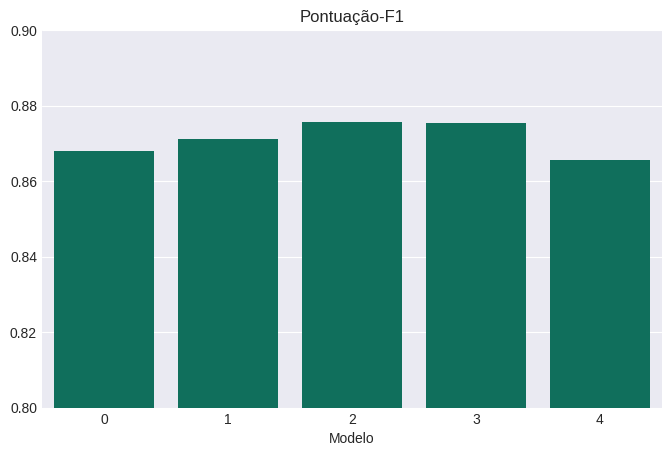

In [56]:
comparacao_f1 = pd.DataFrame([a['pontuacao-f1'] for a in avaliacoes]).T

sns.barplot(data=comparacao_f1, color=COR)

plt.ylim(0.80, 0.90)

plt.title('Pontuação-F1')
plt.xlabel('Modelo')
plt.ylabel('');